In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [72]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [86]:
# 'Sex'を0/1に変換
train_data['Sex_num'] = train_data['Sex'].map({'male':0, 'female':1})
test_data['Sex_num'] = test_data['Sex'].map({'male':0, 'female':1})


#　特徴量（ターゲット変数Survivedを除いた）を数値だけで作る
train_numeric = train_data.drop(columns=['Survived']).select_dtypes(exclude=['object'])
# テストデータも同様に数値だけで作る
test_numeric = test_data.select_dtypes(exclude=['object'])

from sklearn.impute import SimpleImputer

#欠損値補完
my_imputer = SimpleImputer()
imputed_train_data= pd.DataFrame(my_imputer.fit_transform(train_numeric))
imputed_test_data = pd.DataFrame(my_imputer.transform(test_numeric))

imputed_train_data.columns = train_numeric.columns
imputed_test_data.columns = train_numeric.columns


X = imputed_train_data 
#　ターゲット変数をyに代入
y = train_data['Survived']

#モデル学習
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y,train_size =0.8, random_state =0)
# accuracyを出してる
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest_model = RandomForestClassifier(random_state =1)
forest_model.fit(train_X, train_y)
titanic_preds = forest_model.predict(val_X)
print(accuracy_score(val_y, titanic_preds))

test_preds = forest_model.predict(imputed_test_data)

submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_preds})

submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

0.8491620111731844
Your submission was successfully saved!


In [ ]:
# モデルの検証
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# PipelineをClassifierで作り直す！
my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),  # 欠損値の補完
    ('model', RandomForestClassifier(n_estimators=50, random_state=0))  # 分類モデル！
])

# K分割 cross-validation（分類なので scoring='accuracy'）
scores = cross_val_score(my_pipeline, X, y, cv=5, scoring='accuracy')
print("Accuracy scores:\n", scores)
print("Average accuracy:", scores.mean())

In [ ]:
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

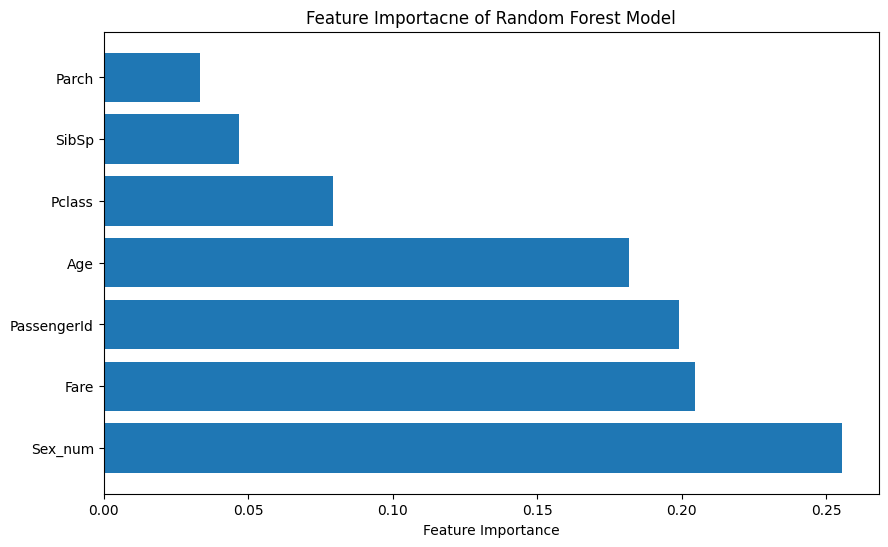

In [88]:
#　特徴量の重要度を取得
importances = forest_model.feature_importances_

# 特徴量名と重要度をペアにしてDataFrameに！
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

#　重要度が高い順にソートします
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 重要度をbarchatで表現
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importacne of Random Forest Model')
plt.show()

In [89]:
y = train_data['Survived']
titanic_features = ['Sex_num', 'Fare','Age', 'Pclass']
X = imputed_train_data[titanic_features]

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state =0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest_model = RandomForestClassifier(random_state = 1)
forest_model.fit(train_X, train_y)
titanic_features_preds = forest_model.predict(val_X)
print(accuracy_score(val_y, titanic_features_preds))

0.8295964125560538
